# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
#### The Goal of this Project
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the project repository.

#### The Writeup

The writeup will be the primary output you submit (along with your code of course).

Within the project repository, there is a writeup template that you can use as a starting point for your project writeup.

A great writeup should include the rubric points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where appropriate) and links to other supporting documents or external references. You should also include images in your writeup to illustrate how your code works.

All that said, please be concise! We're not looking for you to write a book, just a brief description of how you passed each rubric point, and references to the relevant code :)

You are not required to use Markdown for your writeup. If you use another method, please just submit a PDF of your writeup.

#### The Code

Your code should stand on its own as readable material. Explain in code comments, as well as in your writeup, how your code works and why you wrote it that way.

Make it easy for a reviewer to understand your code.

You are more than welcome to use code from the lesson. But if you copy something explain how it works and why you used it.

#### What It Takes to Pass

Read the project rubric for details on the requirements for a passing submission.

Your writeup should include each rubric point and your description of how you addressed that point in your submission. The project repo provides an example template for your writeup.

There is no starter code provided, but you are welcome to use code from the lesson and quizzes as you like. You may complete the project in a Jupyter notebook, but it's not required. Feel free to build it as a standalone project.

To help the reviewer evaluate your project, please save example images from each stage of your pipeline to the output_images folder and provide in your writeup a description of each image. Please also save your output video and include it with your submission.

#### Evaluation

Once you have completed your project, double check the Project Rubric to make sure you have addressed all the rubric points. Your project will be evaluated by a Udacity reviewer according to that same rubric.

Your project must "meet specifications" in each category in order for your submission to pass. If you are happy with your submission, then you are ready to submit! If you see room for improvement in any category in which you do not meet specifications, keep working!

#### Submission

Include a zipped file with your:

* writeup
* code (or a Jupyter notebook)
* example output images
* output video

Alternatively, you may submit a link to your GitHub repo for the project.

---


## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

** sample text 2 **

## Import Packages

In [1]:
#importing some useful packages

import numpy as np
import cv2
import os
import glob
from pickle import dump as pkdump
from pickle import load as pkload
import matplotlib.pyplot as plt
%matplotlib inline

PERFORM_CALIBRATION = False
CREATE_PTF_MTX = False


## Calibrate the Camera

In [2]:
calibrated_p = None

if PERFORM_CALIBRATION:

    print ("Performing calibration...")
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        print (fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imwrite(os.path.splitext(fname)[0] + "_chess.jpg", img)
            #fig = plt.figure()
            #plt.imshow(img)
            #cv2.waitKey(500)

    ret, cal_M, cal_dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    images = glob.glob('camera_cal/*chess.jpg')
    for fname in images:
        print (fname)
        img = cv2.imread(fname)
        img = cv2.undistort(img, cal_M, cal_dist, None, cal_M)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imwrite(os.path.splitext(fname)[0] + "_undist.jpg", img)
        
    
    print ("Storing pickled calibrated data...")
    calibrated_p = { 'mtx': cal_M, 'dist': cal_dist, 'rvecs': rvecs, 'tvecs': tvecs }
    pkdump(calibrated_p, open('calibrated.p', 'wb'))
    print ("Done.")
    
else:
    print ("Loading pickled calibrated data...")
    calibrated_p = pkload(open('calibrated.p', 'rb'))
    print ("Done.")


Loading pickled calibrated data...
Done.


In [3]:
def trans_image(img, x_trans):
    T = np.float32([[1, 0, x_trans], [0, 1, 0]])
    image_tr = cv2.warpAffine(img, T, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST)
    return image_tr

def warp_image_get_M(src_ref_points, dst_ref_points):
    return cv2.getPerspectiveTransform(np.float32(src_ref_points), np.float32(dst_ref_points))

warp_transf_p = None

# perspective based on given 1280x720 images
if CREATE_PTF_MTX:
    
    print ("Creating perspective transform matrix...")
    
    #M = warp_image_get_M(
    #                     [[601, 446], [683, 446], [1046, 681], [274, 681]],
    #                     [[274, 0], [1046, 0], [1046, 681], [274, 681]])
    #M = warp_image_get_M(
    #                     [[601, 446], [683, 446], [1046, 681], [274, 681]],
    #                     [[274, 0], [1046, 0], [1046, 681], [274, 681]])
    #M = warp_image_get_M(
    #                     [[605, 443], [677, 443], [1046, 681], [274, 681]],
    #                     [[274, 0], [1046, 0], [1046, 681], [274, 681]])
    #M = warp_image_get_M(
    #                     [[559, 476], [729, 476], [1046, 681], [274, 681]],
    #                     [[274, 0], [1046, 0], [1046, 681], [274, 681]])

    src_ref_points = [[537, 490], [742, 490], [1087, 720], [193, 720]]
    dst_ref_points = [[436, 350], [844, 350], [850, 720], [430, 720]]
                     #[[436, 350], [844, 350], [844, 720], [436, 720]])

    M = warp_image_get_M(src_ref_points, dst_ref_points)
    Minv = warp_image_get_M(dst_ref_points, src_ref_points)

    print ("Storing pickled warp_transf data...")
    warp_transf_p = { 'M': M, 'Minv': Minv }
    pkdump(warp_transf, open('warp_transf.p', 'wb'))
    print ("Done.")

else:
    print ("Loading pickled warp_transf data...")
    warp_transf_p = pkload(open('warp_transf.p', 'rb'))
    print ("Done.")
    


Loading pickled warp_transf data...
Done.


## Helper Class

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
from math import floor
#from collections import deque

class Filtering:
    def __init__(self, plt=False):
        self.plt = plt

    def abs_sobel_thresh(self, gray, orient='x', sobel_kernel=3, thresh=(0, 255), plt=None, title=''):
        # Calculate directional gradient
        sobel = None
        if orient == 'x':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Apply threshold
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[0])] = 1

        if (self.plt):
            fig = plt.figure();
            fig.suptitle(title+' o='+orient+' k='+str(sobel_kernel)+' th=('+str(thresh[0])+','+str(thresh[1])+')', fontsize=12, fontweight='bold');
            plt.imshow(grad_binary, cmap='gray')
        
        return grad_binary

    def mag_thresh(self, gray, sobel_kernel=3, mag_thresh=(0, 255), plt=None, title=''):
        # Calculate gradient magnitude
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        magn_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
        scaled_sobel = np.uint8(255*magn_sobel/np.max(magn_sobel))
        # Apply threshold
        mag_binary = np.zeros_like(scaled_sobel)
        mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

        if (self.plt):
            fig = plt.figure();
            fig.suptitle(title+' k='+str(sobel_kernel)+' th=('+str(mag_thresh[0])+','+str(mag_thresh[1])+')', fontsize=12, fontweight='bold');
            plt.imshow(mag_binary, cmap='gray')
    
        return mag_binary

    def dir_threshold(self, gray, sobel_kernel=3, thresh=(0, np.pi/2), plt=None, title=''):
        # Calculate gradient direction
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        # Apply threshold
        dir_binary = np.zeros_like(absgraddir)
        dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        if (self.plt):
            fig = plt.figure();
            fig.suptitle(title+' k='+str(sobel_kernel)+' th=('+str(thresh[0])+','+str(thresh[1])+')', fontsize=12, fontweight='bold');
            plt.imshow(dir_binary, cmap='gray')
        
        return dir_binary

    def get_color_channel(self, img, chn=2, thresh=(0, 255), plt=None, title=''):
        channel = img[:,:,chn]
        chn_binary = np.zeros_like(channel)
        chn_binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
        if (self.plt):
            fig = plt.figure();
            fig.suptitle(title+' c='+str(chn)+' th=('+str(thresh[0])+','+str(thresh[1])+')', fontsize=12, fontweight='bold');
            plt.imshow(chn_binary, cmap='gray')
   
        return chn_binary

    def region_of_interest(self, img):
        # defining a blank mask to start with
        img = np.expand_dims(img, axis=2)
        #img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    
        mask = np.zeros_like(img)

        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
        imshape = img.shape
    
        cutoff_y = 0.00
        cutoff_x_l = 0.20
        cutoff_x_r = 0.80
    
        vertices = np.array([[(imshape[1]*0.25, imshape[0]*0.90),
                              (floor(imshape[1]*cutoff_x_l), floor(imshape[0]*cutoff_y)),
                              (floor(imshape[1]*cutoff_x_r), floor(imshape[0]*cutoff_y)),
                              (imshape[1]*0.75, imshape[0]*0.90)]], dtype=np.int32)
        
        # filling pixels inside the polygon defined by "vertices" with the fill color
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        # returning the image only where mask pixels are nonzero
        img_masked = cv2.bitwise_and(img, mask)
        #masked_image = np.squeeze(masked_image)

        return img_masked


class Line:
    def __init__(self):
        #polynomial coefficients for the most recent fit
        self.fit = [0, 0, 0]
        #polynomial coefficients for the most recent fit in meters
        self.fit_metric = [0, 0, 0]
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #crossing the axis x at
        self.xing = 0
        #valid line
        self.valid = False
        # was the line detected in the last iteration?
        self.detected = False
    def print(self):
        print ("fit=[%.5f %.5f %.5f] r=%04d x=%03d v=%d d=%d" % (self.fit[0], self.fit[1], self.fit[2], \
            int(self.radius_of_curvature) if self.radius_of_curvature is not None else 0, \
            int(self.xing*100) if self.xing is not None else 0, \
            int(self.valid), int(self.detected)))


class LaneDetector:
    def __init__(self, cal_M, cal_dist, M, Minv, plot_filtering=True, max_radius_change=1500, max_xing_change=0.2):
        self.last_valid_lines = None # left, right
        self.history_avg_lines = None
        #self.line_history = deque(maxlen=5)
        #self.max_hist = 5
        self.cal_M = cal_M
        self.cal_dist = cal_dist
        self.M = M
        self.Minv = Minv
        self.filtering = Filtering(plot_filtering)
        self.nwindows = 10 # Choose the number of sliding windows
        self.wnd_margin = 50 # Set the width of the windows +/- margin
        self.rc_minpix = 25 # Set minimum number of pixels found to recenter window
        self.ym_per_pix = 40.0/720    # typical lane line is 3.05 meters (10 feet)
        self.xm_per_pix = 3.66/424   # typical lane width is 3.66 meters (12 feet)
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        self.y_eval = 720 * self.ym_per_pix
        self.x_half = 1280/2 * self.xm_per_pix
        self.max_radius_change = 1500
        self.extr_radius_change = 8000
        self.max_xing_change = 20
        self.sq_corr1 = 0.80 # history weight in moving average
        #self.sq_corr2 = 0.90 # history weight in moving average when out of threshold
        #self.sq_corr3 = 0.98 # history weight in moving average when extreme
        self.curr_radius = 0
        self.curr_xing_diff = 0
        self.curr_xing_offt = 0
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        #self.stable_state = False

    def processImage(self, img, reset=False, verbose=False):
        img_ud = self.undistort(img)
        img_warp = self.warp(img_ud)
        img_filt = self.filter(img_warp, plt=False)
        img_crop = self.crop(img_filt)
        (verbose_img, line_l, line_r) = self.higlightLaneLines(img_crop, reset=reset, verbose=verbose)
        self.combineAndAddLines(line_l, line_r, verbose=verbose)
        img_res = self.addOverlay(img_ud, img_warp, line_l, line_r, alpha=0.3)
        img_res = self.addInfotext(img_res)
        return img_res
        
    def undistort(self, img):
        return cv2.undistort(img, self.cal_M, self.cal_dist, None, self.cal_M)
    
    def warp(self, img):
        return cv2.warpPerspective(img, self.M, img.shape[1::-1])
    
    def filter(self, img, plt=False):
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
        self.filtering.plt = plt

        # Apply each of the thresholding functions
        gradx = self.filtering.abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(30, 100), title='gradx')
        #grady = self.filtering.abs_sobel_thresh(gray, orient='y', sobel_kernel=5, thresh=(20, 255), title='grady')
        mag_binary = self.filtering.mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 100), title='mag_binary')
        #dir_binary = self.filtering.dir_threshold(gray, sobel_kernel=15, thresh=(0.65, 1.35), title='dir_binary')
        #l_binary = self.filtering.get_color_channel(hls, chn=1, thresh=(100, 200), plt=plt, title='l_binary')
        s_binary = self.filtering.get_color_channel(hls, chn=2, thresh=(100, 255), title='s_binary')
        #gradx_l = self.filtering.abs_sobel_thresh(hls[:,:,1], orient='x', sobel_kernel=3, thresh=(20, 100), title='gradx_l')
        #gradx_s = self.filtering.abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=3, thresh=(20, 100), title='gradx_s')
        #grady_l = self.filtering.abs_sobel_thresh(hls[:,:,1], orient='y', sobel_kernel=3, thresh=(20, 255), title='grady_l')
        #grady_s = self.filtering.abs_sobel_thresh(hls[:,:,2], orient='y', sobel_kernel=3, thresh=(20, 255), title='grady_s')
        mag_binary_l = self.filtering.mag_thresh(hls[:,:,1], sobel_kernel=13, mag_thresh=(30, 125), title='mag_binary_l')
        mag_binary_s = self.filtering.mag_thresh(hls[:,:,2], sobel_kernel=13, mag_thresh=(30, 125), title='mag_binary_s')
        #dir_binary_l = self.filtering.dir_threshold(hls[:,:,1], sobel_kernel=5, thresh=(0.25, 1.45), title='dir_binary_l')
        dir_binary_s = self.filtering.dir_threshold(hls[:,:,2], sobel_kernel=5, thresh=(0.7, 1.3), title='dir_binary_s')
        #r_binary = self.filtering.get_color_channel(img, chn=0, thresh=(200, 255), title='r_binary')

        img_comb = np.zeros_like(gray)
        #img_comb[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        #img_comb[((gradx == 1) & (grady == 1))] = 1
        #img_comb[(s_binary == 1) & (l_binary == 1) | (mag_binary == 1)] = 1
        #img_comb[(mag_binary_l == 1) | (mag_binary_s == 1)] = 1
        #fig = plt.figure(); fig.suptitle('mag combo', fontsize=12, fontweight='bold'); plt.imshow(img_comb, cmap='gray')

        #img_comb = np.zeros_like(mag_binary)
        #img_comb[(gradx_l == 1) | (gradx_s == 1)] = 1
        #fig = plt.figure(); fig.suptitle('grad combo', fontsize=12, fontweight='bold'); plt.imshow(img_comb, cmap='gray')

        #img_comb[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        #img_comb[((gradx == 1) | (s_binary == 1) | (mag_binary == 1) & (dir_binary_s == 1))] = 1
        #img_comb[(mag_binary_l == 1) | (mag_binary_s == 1) | (mag_binary_l == 1) | (mag_binary_s == 1)] = 1


        img_comb[(((gradx == 1) | (s_binary == 1) | (mag_binary == 1) & (dir_binary_s == 1)) & ((mag_binary_l == 1) | (mag_binary_s == 1)))] = 1

        return img_comb

    def hist(self, bin_img):
        # Take a histogram of the bottom 3/4 of the image
        return np.sum(bin_img[int(bin_img.shape[0]*0.25):,:], axis=0)
        
    def crop(self, img):
        return self.filtering.region_of_interest(img)

    def higlightLaneLines(self, bin_img, reset=False, verbose=False):
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = bin_img.nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        
        line_l = Line()
        line_r = Line()
        
        left_lane_inds  = None
        right_lane_inds = None
        
        verbose_img = None
        if verbose:
            # Create an output image to draw on and visualize the result
            #print ("windowSearch", bin_img.shape)
            verbose_img = np.dstack((bin_img, bin_img, bin_img))*255
            #print ("windowSearch", verbose_img.shape)
        
        if reset:
            self.valid_last_lines = None
            self.history_avg_lines = None
            #self.stable_state = False
            #self.line_history.clear()
        
        if self.last_valid_lines is None:
            (left_lane_inds, right_lane_inds, verbose_img) = self.windowSearch(bin_img, verbose_img, nonzerox, nonzeroy)
        else:
            marg = 100
            line_lr = self.last_valid_lines
            left_lane_inds  = ((nonzerox > (line_lr[0].fit[0]*(nonzeroy**2) + line_lr[0].fit[1]*nonzeroy + line_lr[0].fit[2] - marg)) & (nonzerox < (line_lr[0].fit[0]*(nonzeroy**2) + line_lr[0].fit[1]*nonzeroy + line_lr[0].fit[2] + marg)))
            right_lane_inds = ((nonzerox > (line_lr[1].fit[0]*(nonzeroy**2) + line_lr[1].fit[1]*nonzeroy + line_lr[1].fit[2] - marg)) & (nonzerox < (line_lr[1].fit[0]*(nonzeroy**2) + line_lr[1].fit[1]*nonzeroy + line_lr[1].fit[2] + marg)))

        # Extract left and right line pixel positions
        line_l.allx = nonzerox[left_lane_inds]
        line_l.ally = nonzeroy[left_lane_inds]
        line_r.allx = nonzerox[right_lane_inds]
        line_r.ally = nonzeroy[right_lane_inds]

        if verbose:
            verbose_img[line_l.ally, line_l.allx] = [255, 0, 0]
            verbose_img[line_r.ally, line_r.allx] = [0, 0, 255]
        
        # Fit a second order polynomial to each
        if (len(line_l.allx) >= self.rc_minpix and len(line_l.ally) >= self.rc_minpix):
            line_l.fit = np.polyfit(line_l.ally, line_l.allx, 2)
            line_l.fit_metric = np.polyfit(line_l.ally*self.ym_per_pix, line_l.allx*self.xm_per_pix, 2)
            line_l.detected = True
            if verbose: print (" left_fit", line_l.fit, line_l.fit_metric)
        else:
            line_l.detected = False
            if verbose: print (" left_fit INVALID")
        if (len(line_r.allx) >= self.rc_minpix and len(line_r.ally) >= self.rc_minpix):
            line_r.fit = np.polyfit(line_r.ally, line_r.allx, 2)
            line_r.fit_metric = np.polyfit(line_r.ally*self.ym_per_pix, line_r.allx*self.xm_per_pix, 2)
            line_r.detected = True
            if verbose: print ("right_fit", line_r.fit, line_r.fit_metric)
        else:
            line_r.detected = False
            if verbose: print ("right_fit INVALID")
            
        return verbose_img, line_l, line_r

    def windowSearch(self, bin_img, verbose_img, nonzerox, nonzeroy):
        histogram = self.hist(bin_img)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows
        window_height = np.int(bin_img.shape[0]/self.nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = np.array([], dtype=int)
        right_lane_inds = np.array([], dtype=int)

        #print ("leftx_current:", leftx_current)
        #print ("rightx_current:", rightx_current)    

        # Step through the windows one by one
        for window in range(1, self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = bin_img.shape[0] - (window+1)*window_height
            win_y_high = bin_img.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.wnd_margin
            win_xleft_high = leftx_current + self.wnd_margin
            win_xright_low = rightx_current - self.wnd_margin
            win_xright_high = rightx_current + self.wnd_margin

            if verbose_img is not None:
                # Draw the windows on the visualization image
                cv2.rectangle(verbose_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 4)
                cv2.rectangle(verbose_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 4)

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            #print (win_xleft_low, win_xleft_high)
            #print (win_xright_low, win_xright_high)

            # Append these indices to the lists
            left_lane_inds = np.concatenate((left_lane_inds, good_left_inds), axis=0)
            right_lane_inds = np.concatenate((right_lane_inds, good_right_inds), axis=0)
            #print ("len(left_lane_inds)[" +str(window)+ "]:", len(left_lane_inds))
            #print ("len(right_lane_inds)[" +str(window)+ "]:", len(right_lane_inds))

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.rc_minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                # TODO - sanity check
            if len(good_right_inds) > self.rc_minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            #print (" leftx_current[" +str(window)+ "]:", leftx_current)
            #print ("rightx_current[" +str(window)+ "]:", rightx_current)

            # Concatenate the arrays of indices
            #print (type(left_lane_inds), left_lane_inds.shape)
            #left_lane_inds = np.concatenate(left_lane_inds)
            #print (type(left_lane_inds), left_lane_inds.shape)
            #right_lane_inds = np.concatenate(right_lane_inds)
        
        return left_lane_inds, right_lane_inds, verbose_img

    def calcAvg(self, val, avg, wt):
        return val + wt*(avg - val)
    
    def findCurvature(self, line):
        if line.detected:
            line.radius_of_curvature = int(((1 + (2*line.fit_metric[0]*self.y_eval + line.fit_metric[1])**2)**1.5) / np.absolute(2*line.fit_metric[0]))
            line.xing = line.fit_metric[0]*self.y_eval**2 + line.fit_metric[1]*self.y_eval + line.fit_metric[2]
            line.valid = True
        return line
    
    def combineAndAddLines(self, line_l, line_r, verbose=False):

        #self.history_avg_lines
        
        if self.last_valid_lines is None:
            self.last_valid_lines = [line_l, line_r]
        else:
            line_l = self.findCurvature(line_l)
            line_r = self.findCurvature(line_r)
            
            self.last_valid_lines[0].fit[0] = self.calcAvg(line_l.fit[0], self.last_valid_lines[0].fit[0], self.sq_corr1)
            self.last_valid_lines[0].fit[1] = self.calcAvg(line_l.fit[1], self.last_valid_lines[0].fit[1], self.sq_corr1)
            self.last_valid_lines[0].fit[2] = self.calcAvg(line_l.fit[2], self.last_valid_lines[0].fit[2], self.sq_corr1)
            self.last_valid_lines[1].fit[0] = self.calcAvg(line_r.fit[0], self.last_valid_lines[1].fit[0], self.sq_corr1)
            self.last_valid_lines[1].fit[1] = self.calcAvg(line_r.fit[1], self.last_valid_lines[1].fit[1], self.sq_corr1)
            self.last_valid_lines[1].fit[2] = self.calcAvg(line_r.fit[2], self.last_valid_lines[1].fit[2], self.sq_corr1)
            self.last_valid_lines[0].fit_metric[0] = self.calcAvg(line_l.fit_metric[0], self.last_valid_lines[0].fit_metric[0], self.sq_corr1)
            self.last_valid_lines[0].fit_metric[1] = self.calcAvg(line_l.fit_metric[1], self.last_valid_lines[0].fit_metric[1], self.sq_corr1)
            self.last_valid_lines[0].fit_metric[2] = self.calcAvg(line_l.fit_metric[2], self.last_valid_lines[0].fit_metric[2], self.sq_corr1)
            self.last_valid_lines[1].fit_metric[0] = self.calcAvg(line_r.fit_metric[0], self.last_valid_lines[1].fit_metric[0], self.sq_corr1)
            self.last_valid_lines[1].fit_metric[1] = self.calcAvg(line_r.fit_metric[1], self.last_valid_lines[1].fit_metric[1], self.sq_corr1)
            self.last_valid_lines[1].fit_metric[2] = self.calcAvg(line_r.fit_metric[2], self.last_valid_lines[1].fit_metric[2], self.sq_corr1)
            
        self.last_valid_lines[0] = self.findCurvature(self.last_valid_lines[0])
        self.last_valid_lines[1] = self.findCurvature(self.last_valid_lines[1])

        xing_diff = round(self.last_valid_lines[1].xing - self.last_valid_lines[0].xing, 2)
        xing_offt = int((self.x_half - (self.last_valid_lines[1].xing + self.last_valid_lines[0].xing) / 2.0) * 100) # in centimeters
        radius = int((self.last_valid_lines[1].radius_of_curvature + self.last_valid_lines[0].radius_of_curvature)/2)
        if verbose: print ("radius L/R/Avg = %5d/%5d/%5d m, lane width = %.2f m, offset in lane = %3d cm" % \
            (self.last_valid_lines[0].radius_of_curvature, self.last_valid_lines[1].radius_of_curvature, radius, xing_diff, xing_offt))

        self.curr_radius = radius # Example values: 1926.74 1908.48 
        self.curr_xing_diff = xing_diff
        self.curr_xing_offt = xing_offt        

    def addOverlay(self, img_ud, img_warp, orig_line_l, orig_line_r, alpha):
        # Generate x and y values for plotting
        ploty = np.linspace(0, len(img_ud[2])-1, len(img_ud[2]))
        left_fitx  = self.last_valid_lines[0].fit[0]*ploty**2 + self.last_valid_lines[0].fit[1]*ploty + self.last_valid_lines[0].fit[2]
        right_fitx = self.last_valid_lines[1].fit[0]*ploty**2 + self.last_valid_lines[1].fit[1]*ploty + self.last_valid_lines[1].fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        #print (pts)

        # Create an image to draw the lines on
        poly_base = np.zeros_like(img_warp).astype(np.uint8)
        # Draw the lane onto the warped blank image
        cv2.fillPoly(poly_base, np.int_([pts]), (0, 255, 0)) # BGR

        mask = np.ones_like(img_warp) * 255
        mask[orig_line_l.ally, orig_line_l.allx] = [0, 0, 0]
        mask[orig_line_r.ally, orig_line_r.allx] = [0, 0, 0]
        mask_unwarp = cv2.warpPerspective(mask, ld.Minv, (mask.shape[1], mask.shape[0]), cv2.INTER_LINEAR, borderValue=(255, 255, 255))
        img_ud_bg = cv2.bitwise_and(img_ud, mask_unwarp)
    
        stripes = np.zeros_like(img_warp)
        stripes[orig_line_l.ally, orig_line_l.allx] = [234, 131, 68 ] # (B)GR
        stripes[orig_line_r.ally, orig_line_r.allx] = [ 89,  49, 253] # BG(R)
        stripes_fg = cv2.warpPerspective(stripes, ld.Minv, (mask.shape[1], mask.shape[0]))
    
        img_ud_stripes = cv2.add(img_ud_bg, stripes_fg)

        #plt.figure()
        #plt.imshow(mask_unwarp, cmap='gray')
        #plt.figure()
        #plt.imshow(cv2.cvtColor(img_ud_bg, cv2.COLOR_BGR2RGB))
        #plt.figure()
        #plt.imshow(cv2.cvtColor(stripes_fg, cv2.COLOR_BGR2RGB))
        #plt.figure()
        #plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
        #cv2.imwrite("out"+str(i)+".png", img_out)
        #i += 1
            
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        poly_base_unwarp = cv2.warpPerspective(poly_base, self.Minv, (poly_base.shape[1], poly_base.shape[0]))

        #plt.imshow(newwarp)
        #continue
        # Combine the result with the original image
        img_res = cv2.addWeighted(img_ud_stripes, 1,  poly_base_unwarp, alpha, 0)
        return img_res

    def addInfotext(self, img):

        cv2.putText(img, 'Rad=%dm' % self.curr_radius, (30,50), self.font, 2, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(img, 'Width=%.2fm' % self.curr_xing_diff, (30,110), self.font, 2, (255,255,255), 2, cv2.LINE_AA) 
        cv2.putText(img, 'Offt=%dcm' % self.curr_xing_offt, (30,170), self.font, 2, (255,255,255), 2, cv2.LINE_AA) 
        
        return img
    
ld = LaneDetector(calibrated_p['mtx'], calibrated_p['dist'], warp_transf_p['M'], warp_transf_p['Minv'], plot_filtering=True)

### Undistort+Warp - test

Build your pipeline to work on the images in the directory "test_images"

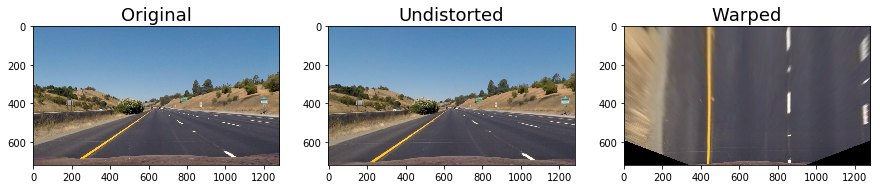

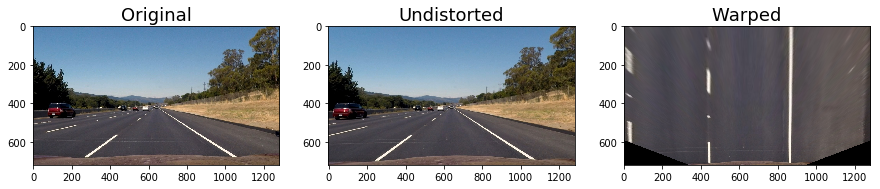

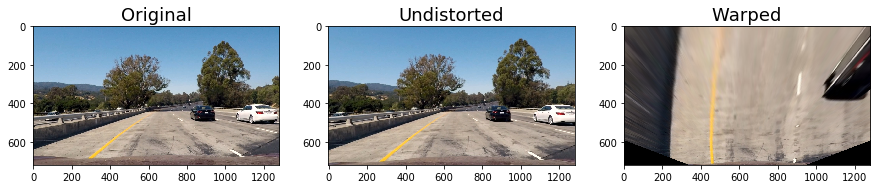

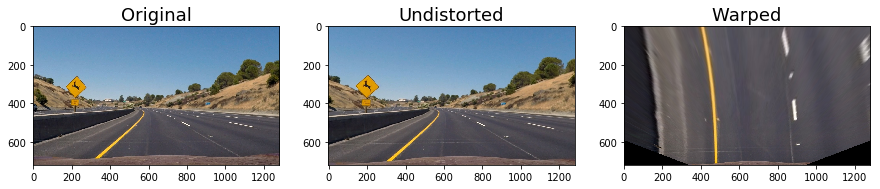

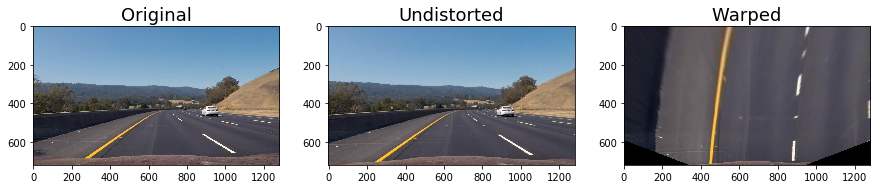

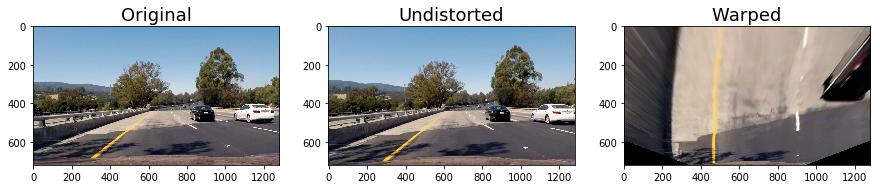

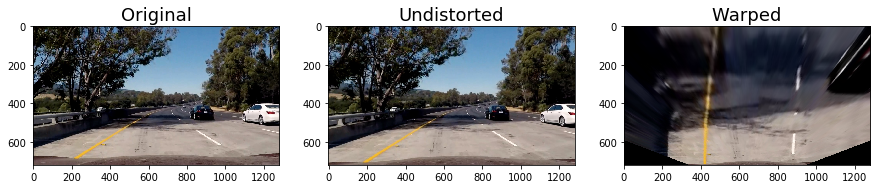

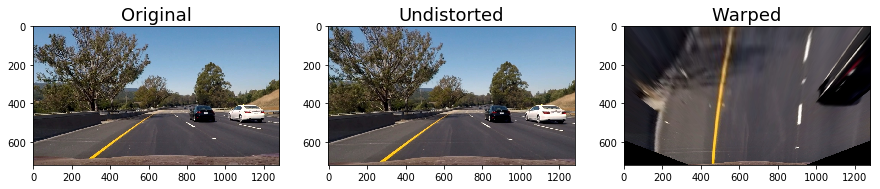

In [5]:
fnames_orig = glob.glob('test_images/*.jpg')

imgs_undist = []

for fname in fnames_orig:
    img = cv2.imread(fname)
    
    fig = plt.figure(figsize=(15, 3))
    left_part = fig.add_subplot(1, 3, 1)
    left_part.set_title('Original', fontsize=18)
    left_part.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    img_ud = ld.undistort(img)
    imgs_undist.append(img_ud)
    
    center_part = fig.add_subplot(1, 3, 2)
    center_part.set_title('Undistorted', fontsize=18)
    center_part.imshow(cv2.cvtColor(img_ud, cv2.COLOR_BGR2RGB))    
    
    cv2.imwrite(os.path.splitext(fname)[0] + "_undst.png", img_ud)

    img_warp = ld.warp(img_ud)
    
    right_part = fig.add_subplot(1, 3, 3)
    right_part.set_title('Warped', fontsize=18)
    right_part.imshow(cv2.cvtColor(img_warp, cv2.COLOR_BGR2RGB))    
    
    cv2.imwrite(os.path.splitext(fname)[0] + "_wrp.png", img_warp)    
    
plt.show()

### Filtering - test

Filtering warped images

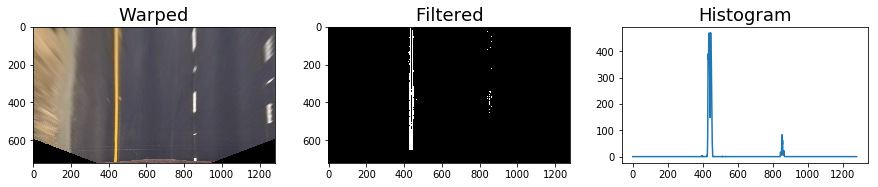

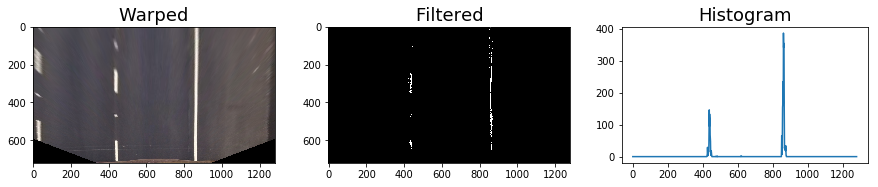

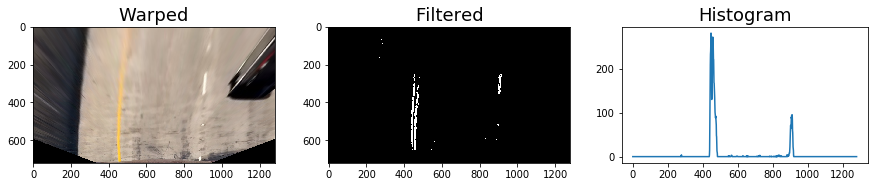

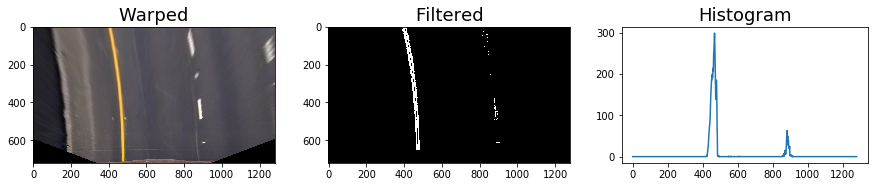

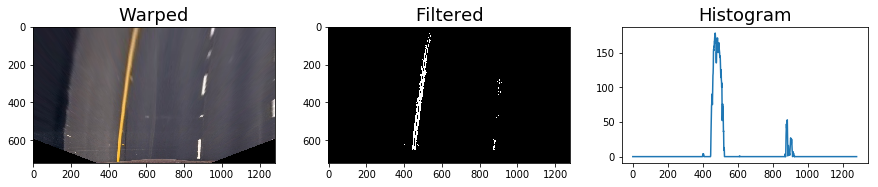

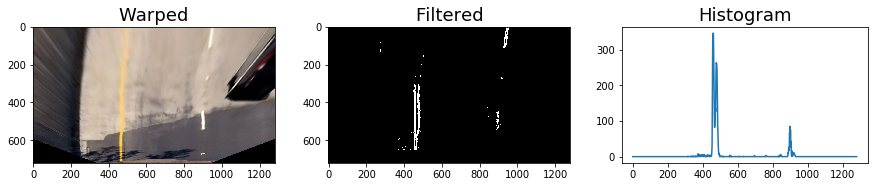

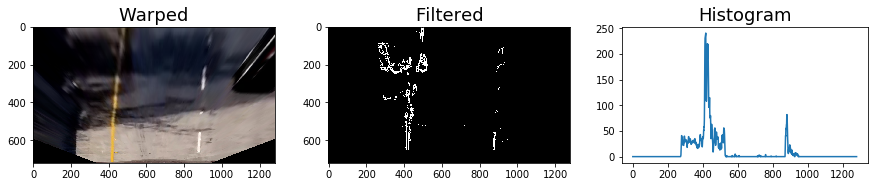

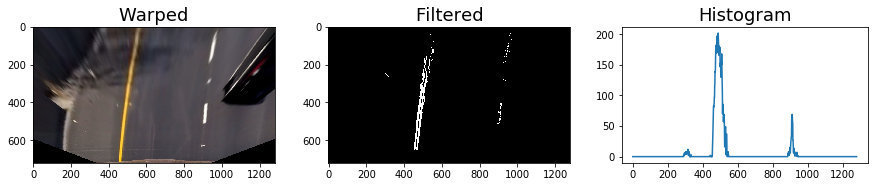

In [6]:
fnames_warp = glob.glob('test_images/*_wrp.png')

imgs_warp = []

for fname in fnames_warp:
    img_warp = cv2.imread(fname)
    
    fig = plt.figure(figsize=(15, 2.5))
    left_part = fig.add_subplot(1, 3, 1)
    left_part.set_title('Warped', fontsize=18)
    left_part.imshow(cv2.cvtColor(img_warp, cv2.COLOR_BGR2RGB))
    imgs_warp.append(img_warp)

    img_filt = ld.filter(img_warp, plt=False)
    img_filt = ld.crop(img_filt)
    
    center_part = fig.add_subplot(1, 3, 2)
    center_part.set_title('Filtered', fontsize=18)
    center_part.imshow(img_filt, cmap='gray')    

    histogram = ld.hist(img_filt)
    
    right_part = fig.add_subplot(1, 3, 3)
    right_part.set_title('Histogram', fontsize=18)
    right_part.plot(histogram)
    
    cv2.imwrite(os.path.splitext(fname)[0] + "_filt.png", img_filt)

plt.show()

fnames_filt = glob.glob('test_images/*_filt.png')

### Lane finding - test

Filtering warped images

 left_fit [ -2.29729813e-05   1.62282443e-02   4.37753075e+02] [ -6.42506608e-05   2.52150173e-03   3.77871758e+00]
right_fit [ -1.44288666e-05   1.35763909e-02   8.50851067e+02] [ -4.03545451e-05   2.10946376e-03   7.34461062e+00]
 left_fit [  2.20364962e-05  -1.20024652e-02   4.39384579e+02] [  6.16315063e-05  -1.86491133e-03   3.79280085e+00]
right_fit [  4.90596927e-06  -1.55356208e-02   8.66900357e+02] [  1.37209778e-05  -2.41388372e-03   7.48314931e+00]
 left_fit [  6.86606667e-05  -1.02159914e-01   4.88846894e+02] [  1.92029634e-04  -1.58733376e-02   4.21976328e+00]
right_fit [  9.62112824e-05  -1.35516054e-01   9.39791540e+02] [  2.69082989e-04  -2.10561265e-02   8.11235150e+00]
 left_fit [ -1.67542028e-04   2.16592025e-01   4.03442102e+02] [ -4.68580279e-04   3.36534967e-02   3.48254267e+00]
right_fit [ -1.29182995e-04   2.01408603e-01   8.21004887e+02] [ -3.61298026e-04   3.12943367e-02   7.08697614e+00]
 left_fit [  4.42042627e-05  -1.62594615e-01   5.41085134e+02] [  1.2363

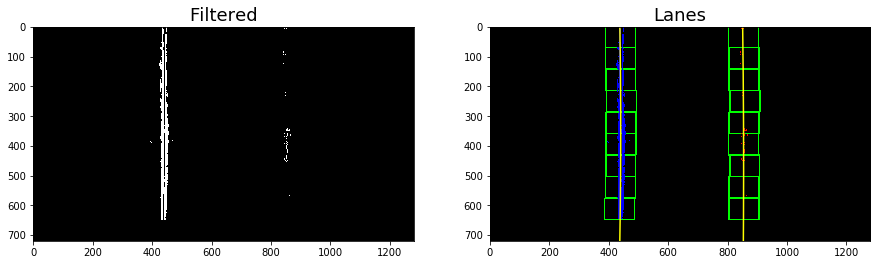

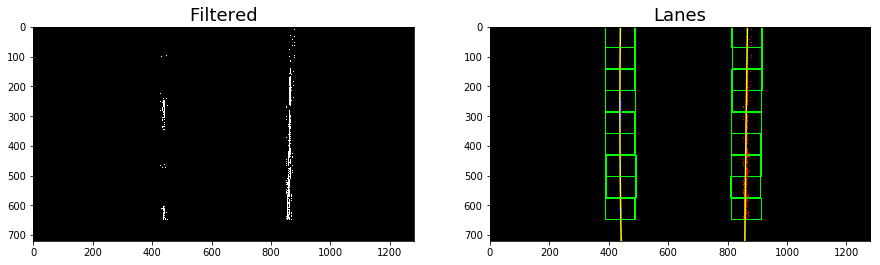

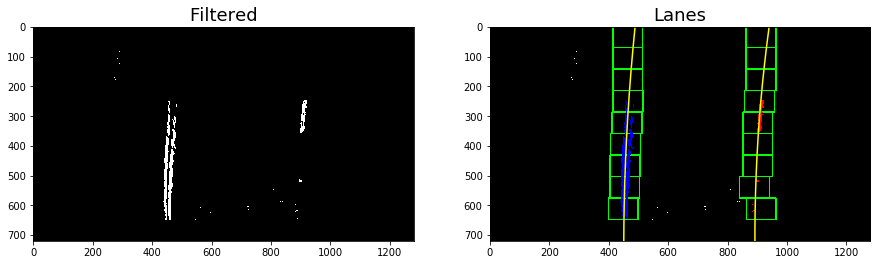

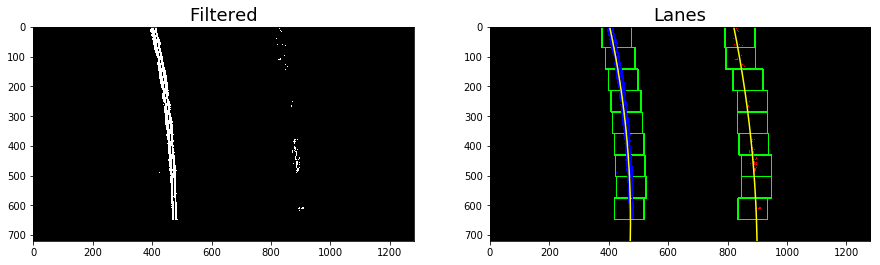

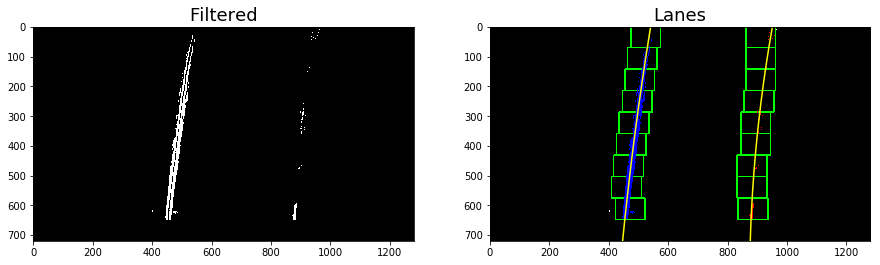

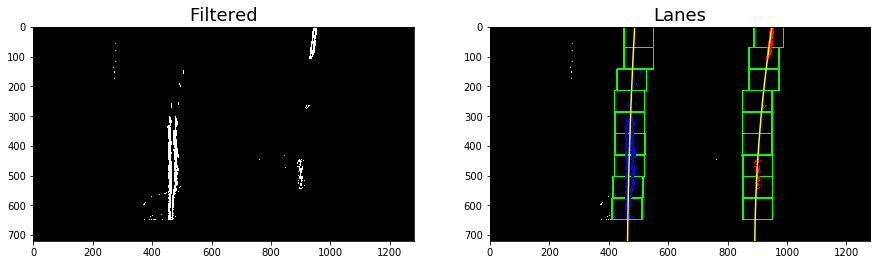

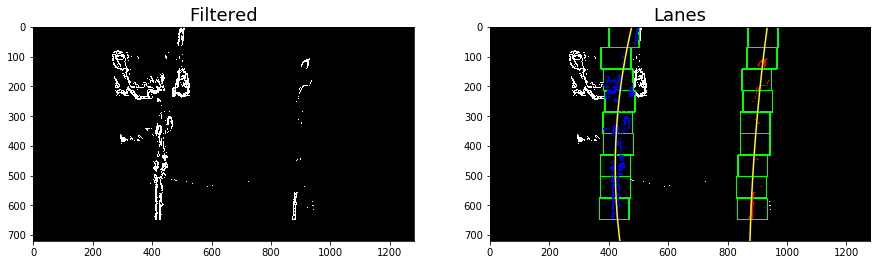

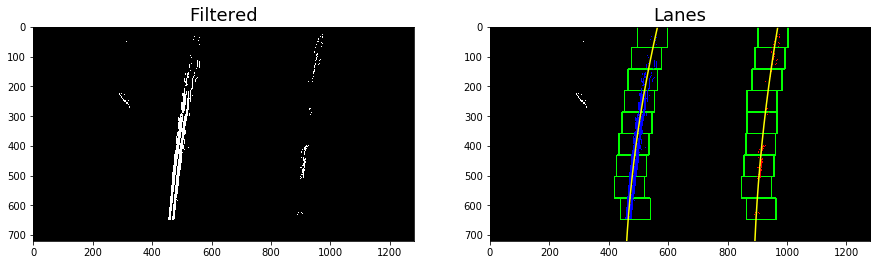

In [7]:
lines = []

for fname in fnames_filt:
    bin_img = cv2.imread(fname)
    bin_img = bin_img[:,:,0]
    
    fig = plt.figure(figsize=(15, 6))
    left_part = fig.add_subplot(1, 2, 1)
    left_part.set_title('Filtered', fontsize=18)
    left_part.imshow(bin_img, cmap='gray')
    
    (verbose_img, line_l, line_r) = ld.higlightLaneLines(bin_img, reset=True, verbose=True)
    lines.append([line_l, line_r])

    # Generate x and y values for plotting
    ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0] )
    left_fitx  = line_l.fit[0]*ploty**2 + line_l.fit[1]*ploty + line_l.fit[2]
    right_fitx = line_r.fit[0]*ploty**2 + line_r.fit[1]*ploty + line_r.fit[2]

    right_part = fig.add_subplot(1, 2, 2)
    right_part.set_title('Lanes', fontsize=18)
    right_part.plot(left_fitx, ploty, color='yellow')
    right_part.plot(right_fitx, ploty, color='yellow')
    #right_part.xlim(0, 1280)
    #right_part.ylim(720, 0)    
    right_part.imshow(cv2.cvtColor(verbose_img, cv2.COLOR_BGR2RGB))

    #my0_left = 2*left_fit[0]*0 + left_fit[1]
    #my0_right = 2*right_fit[0]*0 + right_fit[1]
    #print (my0_left, my0_right)

    #fig = plt.figure();
    #plt.imshow(out_img)

plt.show()

### Calculating curvature - test

In [8]:
line_stats = []
for linefit_lr in lines:
    ld.stable_state = False
    ld.combineAndAddLines(linefit_lr[0], linefit_lr[1], verbose=True)
    line_stats.append([ld.curr_radius, ld.curr_xing_diff, ld.curr_xing_offt])


radius L/R/Avg =  7782/12390/10086 m, lane width = 3.59 m, offset in lane =  -4 cm
radius L/R/Avg = 12796/16926/14861 m, lane width = 3.59 m, offset in lane =  -5 cm
radius L/R/Avg = 69964/16564/43264 m, lane width = 3.63 m, offset in lane =  -9 cm
radius L/R/Avg =  5681/10392/ 8036 m, lane width = 3.64 m, offset in lane = -15 cm
radius L/R/Avg = 10947/26688/18817 m, lane width = 3.66 m, offset in lane = -16 cm
radius L/R/Avg = 25254/ 7140/16197 m, lane width = 3.66 m, offset in lane = -19 cm
radius L/R/Avg =  4055/ 5124/ 4589 m, lane width = 3.69 m, offset in lane = -18 cm
radius L/R/Avg =  3046/ 3930/ 3488 m, lane width = 3.69 m, offset in lane = -21 cm


### Visualizing result

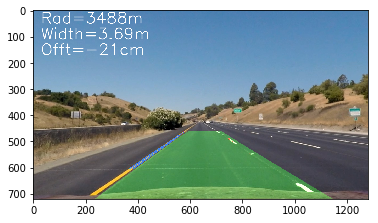

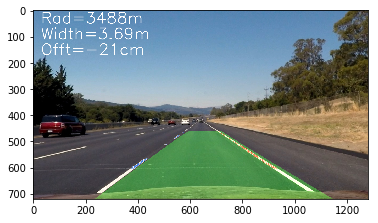

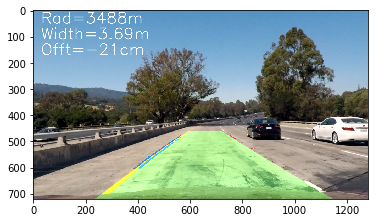

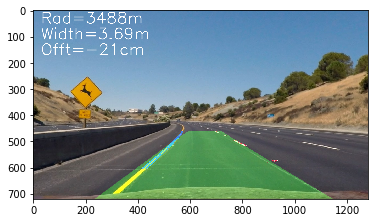

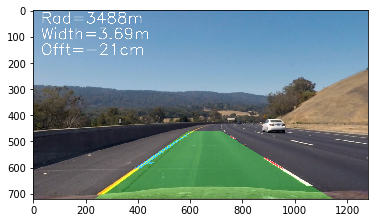

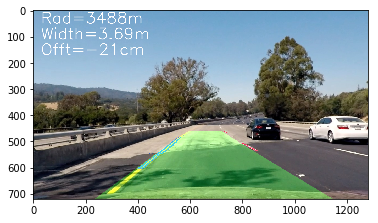

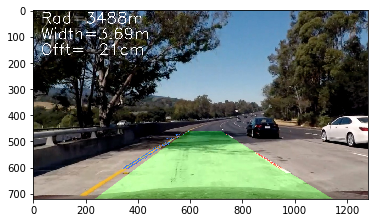

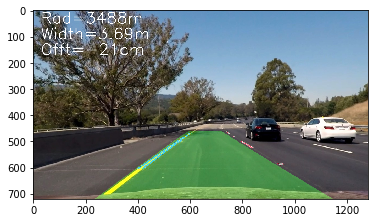

In [9]:
i = 1

for (img_ud, img_warp, line_lr, line_stat) in zip(imgs_undist, imgs_warp, lines, line_stats):
    fig = plt.figure()
    img_res = ld.addOverlay(img_ud, img_warp, line_lr[0], line_lr[1], alpha=0.3)
    img_res = ld.addInfotext(img_res)
    plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))
    
    #cv2.imwrite("out"+str(i)+".png", img_res)
    #i += 1
    
plt.show()

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

Processing test_images\straight_lines1.jpg...
 left_fit [ -2.14366191e-05   1.53846959e-02   4.37834199e+02] [ -5.99537746e-05   2.39043341e-03   3.77941785e+00]
right_fit [ -1.44288666e-05   1.35763909e-02   8.50851067e+02] [ -4.03545451e-05   2.10946376e-03   7.34461062e+00]
radius L/R/Avg =  4191/ 5336/ 4763 m, lane width = 3.67 m, offset in lane = -17 cm
Processing test_images\straight_lines2.jpg...
 left_fit [  2.30400264e-05  -1.27327232e-02   4.39505682e+02] [  6.44381719e-05  -1.97837689e-03   3.79384622e+00]
right_fit [  5.21477759e-06  -1.57237080e-02   8.66922204e+02] [  1.45846506e-05  -2.44310822e-03   7.48333789e+00]
radius L/R/Avg =  4616/ 6420/ 5518 m, lane width = 3.66 m, offset in lane = -16 cm
Processing test_images\test1.jpg...
 left_fit [  7.92842464e-05  -1.11175615e-01   4.90680014e+02] [  2.21741582e-04  -1.72741734e-02   4.23558692e+00]
right_fit [ -1.98451074e-04   5.83844132e-02   9.08549076e+02] [ -5.55026465e-04   9.07161590e-03   7.84266419e+00]
radius L/R

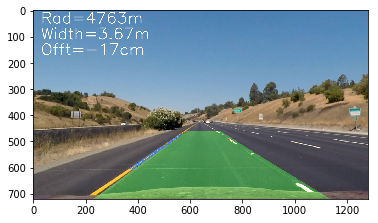

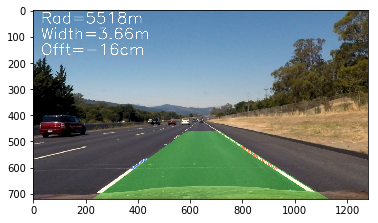

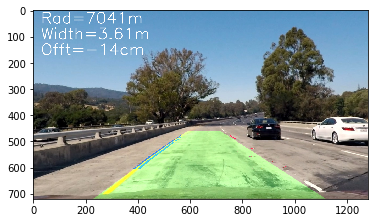

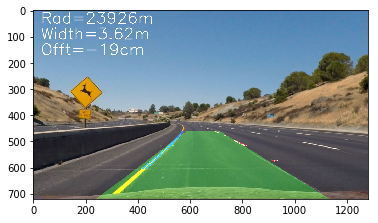

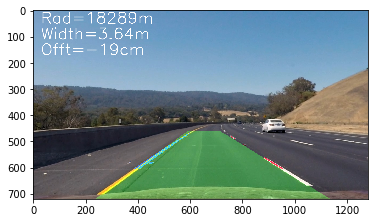

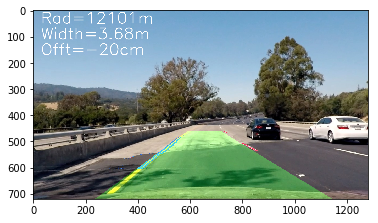

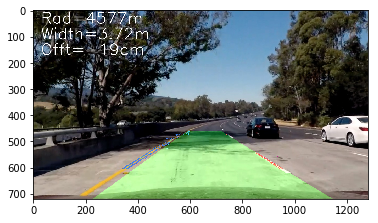

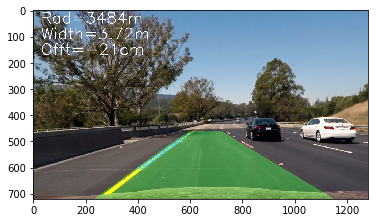

In [10]:
fnames_orig = glob.glob('test_images/*.jpg')
ld.stable_state = False
for fname in fnames_orig:
    print ("Processing %s..." % fname)
    plt.figure()
    img = cv2.imread(fname)
    
    img_res = ld.processImage(img, reset=True, verbose=True)
    plt.imshow(cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB))
    cv2.imwrite("output_images/" + os.path.basename(fname), img_res)
plt.show()

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

t_from = 37
t_till = 44

#vidoe_output = 'project_video_out_' + str(t_from) + "-" + str(t_till) + '.mp4'
vidoe_output = 'project_video_out_full.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

ld_video = LaneDetector(calibrated_p['mtx'], calibrated_p['dist'], warp_transf_p['M'], warp_transf_p['Minv'], plot_filtering=False, max_radius_change=1400, max_xing_change=0.20)

clip1 = VideoFileClip('project_video.mp4') #.subclip(t_from,t_till)
clip1_out = clip1.fl_image(ld_video.processImage)
%time clip1_out.write_videofile(vidoe_output, audio=False)

[MoviePy] >>>> Building video project_video_out_full.mp4
[MoviePy] Writing video project_video_out_full.mp4


100%|█████████████████████████████████████▉| 1260/1261 [09:30<00:00,  2.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_full.mp4 

Wall time: 9min 33s


#### Processing a video

In [12]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vidoe_output))